In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

2024-01-29 16:28:09.088100: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 16:28:09.255659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 16:28:09.255904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 16:28:09.285521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 16:28:09.350650: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 16:28:09.351703: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.8123 - accuracy: 0.3696
Epoch 1: val_loss improved from inf to 0.64228, saving model to glaucoma_detection_model.h5


/home/jhenrique/myenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 158s 8s/step - loss: 0.8123 - accuracy: 0.3696 - val_loss: 0.6423 - val_accuracy: 0.7347 - lr: 1.0000e-06
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 40.5723 - accuracy: 0.5888
Epoch 2: val_loss did not improve from 0.64228
18/18 [==============================] - 138s 8s/step - loss: 40.5723 - accuracy: 0.5888 - val_loss: 13600730218235335884668928.0000 - val_accuracy: 0.7347 - lr: 0.0500
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7428
Epoch 3: val_loss improved from 0.64228 to 0.59354, saving model to glaucoma_detection_model.h5
18/18 [==============================] - 138s 8s/step - loss: 0.6605 - accuracy: 0.7428 - val_loss: 0.5935 - val_accuracy: 0.7347 - lr: 0.1000
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.7428
Epoch 4: val_loss improved from 0.59354 to 0.58496, saving model to glaucoma_detection_model.h5
18/18 [============

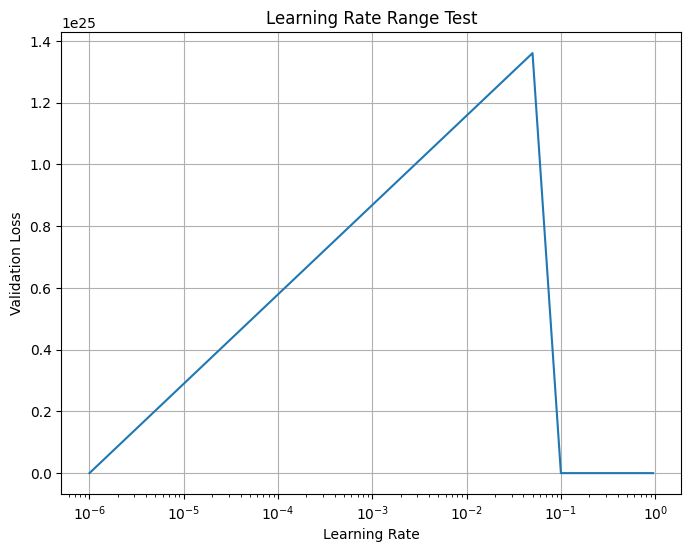

In [2]:
annotations = pd.read_csv('archive/glaucoma.csv')

img_width, img_height = 224, 224
batch_size = 32

image_folder = 'archive/ORIGA/ORIGA/Images/'
image_paths = [os.path.join(image_folder, filename) for filename in annotations['Filename']]
images = [cv2.resize(cv2.imread(img_path), (img_width, img_height)) for img_path in image_paths]
images = np.array(images) / 255.0 

labels = annotations['Glaucoma'].values

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_data_generator = validation_datagen.flow(X_val, y_val, batch_size=batch_size)

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

initial_learning_rate = 1e-6
final_learning_rate = 1.0

num_epochs = 20

def lr_scheduler(epoch, lr):
    return initial_learning_rate + (final_learning_rate - initial_learning_rate) * (epoch / num_epochs)

model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('glaucoma_detection_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(
    train_data_generator,
    validation_data=validation_data_generator,
    epochs=num_epochs,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), checkpoint, early_stopping],
)

# Plot learning rate range test
learning_rates = [initial_learning_rate + (final_learning_rate - initial_learning_rate) * (epoch / num_epochs) for epoch in range(num_epochs)]
validation_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.semilogx(learning_rates, validation_loss)
plt.title('Learning Rate Range Test')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()